# **CHAPTER 3. 분류**


## **1. MNIST**

* MNIST: 손으로 쓴 70,000개의 작은 숫자 이미지를 모은 데이터셋

In [ ]:
# MNIST 데이터셋 내려받기
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

* 사이킷런에서 읽어 들인 데이터셋들은 일반적으로 비슷한 딕셔너리 구조를 갖고 있음

    * 데이터셋을 설명하는 DESCR 키

    * 샘플이 하나의 행, 특성이 하나의 열로 구성된 배열을 가진 data 키

    * 레이블 배열을 담은 target 키

In [ ]:
# 배열들 살펴보기
X, y = mnist["data"], mnist["target"]
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


>> 이미지가 70,000개 있고 각 이미지에는 784개의 특성이 있음

>> 이미지가 28X28 픽셀이기 때문

>> 개개의 특성은 0(흰색)부터 255(검은색)까지의 픽셀 강도를 나타냄

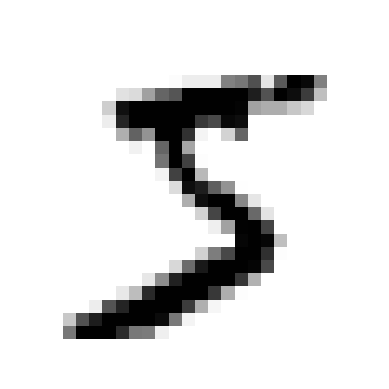

In [ ]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

# 샘플의 특성 벡터를 추출해서 28X28 배열로 크기를 바꾸고 imshow()를 사용해 그림
some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [ ]:
# 위 그림의 실제 레이블 확인
y[0]

'5'

>> 레이블은 문자열임

In [ ]:
# y를 정수로 변환
y = y.astype(np.uint8)

* 데이터를 조사하기 위해 항상 테스트 세트를 만들고 따로 떼어 놓아야 함

In [ ]:
# 앞쪽 60,000개가 훈련 세트, 뒤에 10,000개가 테스트 세트임
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

---

## **2. 이진 분류기 훈련**

* '5'와 '5 아님' 두 개의 클래스를 구분할 수 있는 이진 분류기 만들기

In [ ]:
# 타깃 벡터 만들기
y_train_5 = (y_train == 5) # 5는 True고, 다른 숫자는 모두 False
y_test_5 = (y_test == 5)

* 사이킷런의 `SGDClassifier`: 확률적 경사 하강법 분류기

    -> 매우 큰 데이터셋을 효율적으로 처리하는 장점을 지니고 있음

    -> SGD가 한 번에 하나씩 훈련 샘플을 독립적으로 처리하기 때문

In [ ]:
# 모델 생성 및 훈련
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [ ]:
sgd_clf.predict([some_digit])

array([ True])

>> 분류기가 이 이미지가 5를 나타낸다고 추측함

---

## **3. 성능 측정**

* 분류기 평가는 사용할 수 있는 성능 지표가 많음

### **3-1. 교차 검증을 사용한 정확도 측정**

* StratifiedKFold: 클래스별 비율이 유지되도록 폴드를 만들기 위해 계층적 샘플링을 수행

    -> 매 반복에서 분류기 객체를 복제하여 훈련 폴드로 훈련시키고 테스트 폴드로 예측

    -> 올바른 예측의 수를 세어 정확한 예측의 비율을 출력

* k-겹 교차 검증: 훈련 세트를 k개의 폴드로 나누고, 각 폴드에 대해 예측을 만들고 평가하기 위해 나머지 폴드로 훈련시킨 모델을 사용

In [ ]:
# cross_val_score() 함수과 거의 같은 작업을 수행하고 동일한 결과를 출력
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))


0.9669
0.91625
0.96785


In [ ]:
# cross_val_score()로 SGDClassifier 모델 평가
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

>> 모든 교차 검증 폴드에 대해 정확도가 95% 이상임

In [ ]:
# 모든 이미지를 '5 아님' 클래스로 분류하는 더미 분류기 생성
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [ ]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

>> 이미지의 10% 정도만 숫자 5이기 때문에 정확도가 90%가 나옴

>> 따라서 정확도를 분류기의 성능 측정 지표로 선호하지 않음 (특히 불균형한 데이터셋을 다룰 때)

---

### **3-2. 오차 행렬**

* 분류기의 성능을 평가하는 더 좋은 방법은 오차 행렬을 조사하는 것

* 오차 행렬을 만들려면 실제 타깃과 비교할 수 있도록 먼저 예측값을 만들어야 함

* 테스트 세트는 맨 마지막에 사용하므로 `cross_val_predict()` 사용


* `cross_val_predict()`: `cross_val_score()`처럼 k-겹 교차 검증을 수행하지만 평가 점수를 반환하지 않고 각 테스트 폴드에서 얻은 예측을 반환

In [ ]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [ ]:
# 타깃 클래스와 예측 클래스를 넣고 호출
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

>> 오차 행렬의 행: 실제 클래스, 열: 예측한 클래스

>> 첫 번째 행: 음성 클래스, 두 번째 행: 양성 클래스



* 완벽한 분류기라면 진짜 양성과 진짜 음성만 가지고 있을 것이므로 오차 행렬의 주대각선만 0이 아닌 값이 됨


In [ ]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

---

### **3-3. 정밀도와 재현율**

* 정밀도: 양성 예측의 정확도 = TP / (TP + FP) (TP: 진짜 양성의 수, FP: 거짓 양성의 수)

* 재현율: 정확하게 감지한 양성 샘플의 비율 = TP / (TP + FN) (TP: 진짜 양성의 수, FN: 거짓 음성의 수)

In [ ]:
from sklearn.metrics import precision_score, recall_score

# 정밀도
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [ ]:
# 재현율
recall_score(y_train_5, y_train_pred)

0.6511713705958311

* F1 점수: 정밀도와 재현율의 조화 평균

    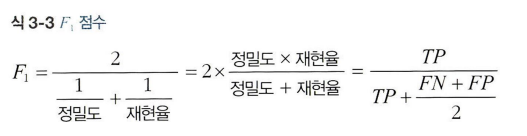

In [ ]:
from sklearn.metrics import f1_score

# F1 점수
f1_score(y_train_5, y_train_pred)

0.7325171197343846

* 정밀도와 재현율이 비슷하면 F1 점수가 높음

* 하지만 상황에 따라 정밀도가 중요할 수도 있고 재현율이 중요할 수도 있음

    ex) 어린아이에게 안전한 동영상을 걸러내는 분류기를 훈련시킨다고 가정하면 좋은 동영상이 많이 제외되더라도(낮은 재현율) 안전한 것들만 노출시키는(높은 정밀도) 분류기를 선호

---

### **3-4. 정밀도/재현율 트레이드오프**

* 정밀도/재현율 트레이드오프: 정밀도를 올리면 재현율이 줄고, 정밀도가 줄면 재현율이 올라감

* `SGDClassifier`는 결정 함수를 사용하여 각 샘플의 점수를 계산함

    -> 이 점수가 임곗값보다 크면 샘플을 양성 클래스에 할당하고 그렇지 않으면 음성 클래스에 할당함

    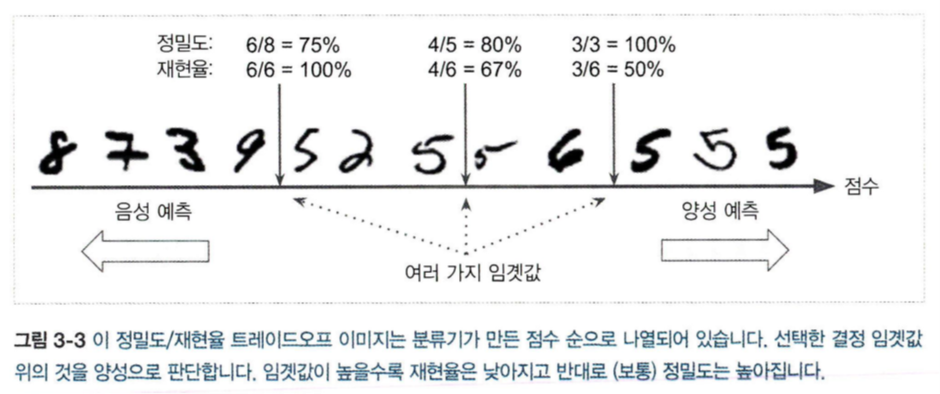

* 사이킷런에서 임곗값을 직접 지정할 수는 없지만 예측에 사용한 점수는 확인할 수 있음

* 분류기의 `predict()` 대신 `decision_function()` 메서드를 호출하면 각 샘플의 점수를 얻을 수 있음

    -> 이 점수를 기반으로 원하는 임곗값을 정해 예측을 만들 수 있음

In [ ]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [ ]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

>> 임곗값을 0으로 설정했으므로 True를 반환함

In [ ]:
# 임곗값 높이기
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

>> 이 결과는 임곗값을 높이면 재현율이 줄어든다는 것을 보여줌

* 적절한 임곗값을 구하기 위해서는 먼저 `cross_val_predict()` 함수를 사용해 훈련 세트에 있는 모든 샘플의 점수를 구해야함

    -> 이때 예측 결과가 아닌 결정 점수를 반환받도록 지정해야 함

    -> 이 점수로 `precision_recall_curve()` 함수를 사용하여 가능한 모든 임곗값에 대해 정밀도와 재현율을 계산할 수 있음

In [ ]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3 , method="decision_function")

In [ ]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

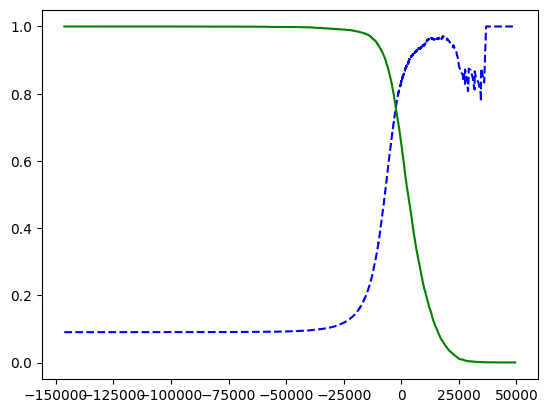

In [ ]:
# 맷플롯립을 이용해 임곗값의 함수로 정밀도와 재현율을 그림
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="정밀도")
    plt.plot(thresholds, recalls[:-1], "g-", label="재현율")
    [...] # 임곗값을 표시하고 범례, 축 이름, 그리드를 추가

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

>> 임곗값이 올라가면 보통 정밀도는 높아지지면 가끔 낮아질 때가 있어 울퉁불퉁함

>> 그러나 재현율은 임곗값이 올라가면 무조건 줄어들어 부드러운 곡선이 됨

* 좋은 정밀도/재현율 트레이드오프를 선택하는 다른 방법은 재현율에 대한 정밀도 곡선을 그리는 것임

    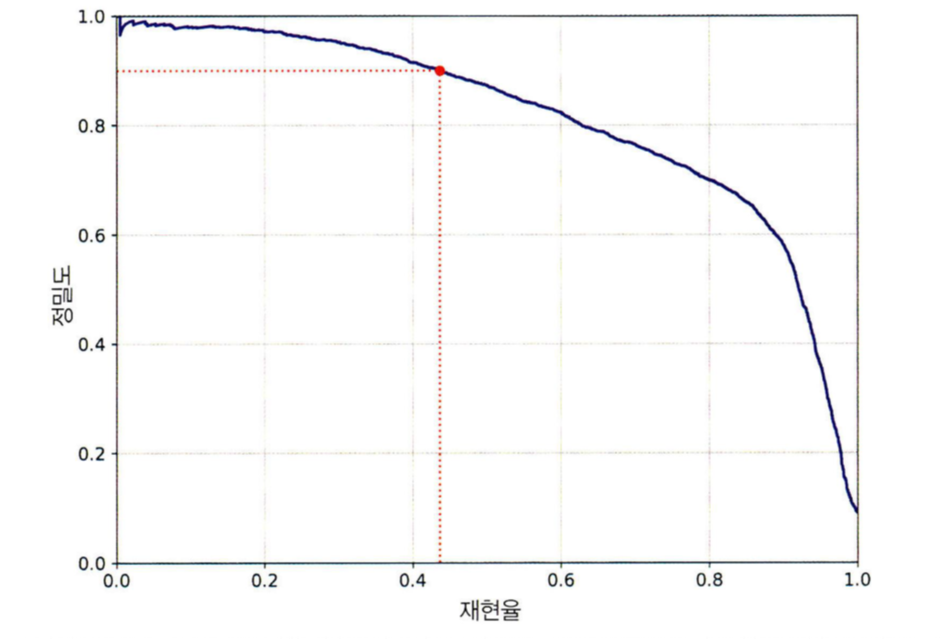

    -> 재현율 80% 근처에서 정밀도가 급격하게 줄어들기 시작함

    -> 이 하강점 직전을 정밀도/재현율 트레이드오프로 선택하는 것이 좋음 (ex. 재현율이 60% 정도인 지점)

In [ ]:
# 정밀도가 최소 90%가 되는 가장 낮은 임곗값 찾기
threshold_90_precision = thresholds[np.argmax(precisions>=0.90)]
threshold_90_precision

3370.0194991439557

In [ ]:
# 훈련 세트에 대한 예측 만들기
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [ ]:
# 정밀도 확인
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [ ]:
# 재현율 확인
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

---

### **3-5. ROC 곡선**

* ROC 곡선: 거짓 양성(FP) 비율에 대한 진짜 양성(TP) 비율의 곡선

* 특이도: 진짜 음성(TN) 비율

* ROC 곡선을 그리려면 먼저 `roc_curve()` 함수를 이용해 여러 임곗값에서 TPR과 FPR을 계산 해야함

* 트레이드오프: 재현율(TPR)이 높을수록 분류기가 만드는 거짓 양성(FPR)이 늘어남

* 좋은 분류기는 점선에서 최대한 멀리 떨어져 있어야 함 (왼쪽 위 모서리)

* AUC: 곡선 아래의 면적
    
    -> 완벽한 분류기는 ROC의 AUC가 1이고, 완전한 랜덤 분류기는 0.5임

* 양성 클래스가 드물거나 거짓 음성보다 거짓 양성이 더 중요할 때 PR 곡선을 사용하고 그렇지 않으면 ROC 곡선을 사용

In [ ]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

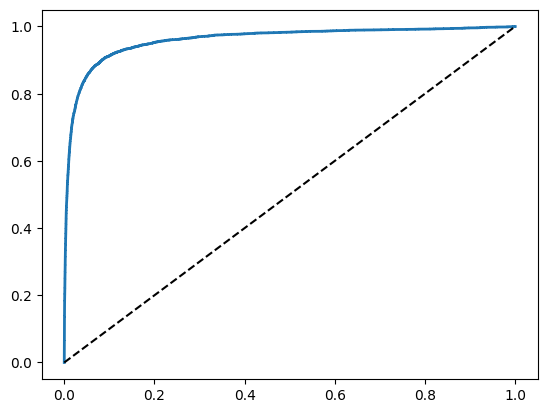

In [ ]:
# TPR에 대한 FPR 곡선
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--') # 대각 점선
    [...] # 축 이름, 그리드 추가

plot_roc_curve(fpr, tpr)
plt.show()

In [ ]:
# AUC 구하기
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

* 사이킷런 분류기는 일반적으로 `decision_function()`, `predict_proba()` 메서드 중 하나 또는 둘 모두를 갖고 있음

* `predict_proba()`: 샘플이 행, 클래스가 열이고 샘플이 주어진 클래스에 속할 확률을 담은 배열을 반환

In [ ]:
# 훈련 세트의 샘플에 대한 점수 얻기
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [ ]:
# roc_curve() 함수는 레이블과 점수를 기대
y_scores_forest = y_probas_forest[:, 1] # 양성 클래스에 대한 확률을 점수로 사용
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

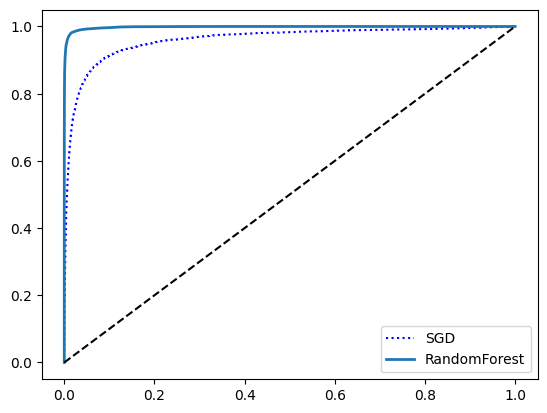

In [ ]:
# 랜덤포레스트와 SGD 분류기 비교
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "RandomForest")
plt.legend(loc="lower right")
plt.show()

>> 랜덤포레스트의 ROC 곡선이 왼쪽 위 모서리에 더 가깝기 때문에 SGD 분류기보다 훨씬 좋음

In [ ]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

>> ROC AUC 점수도 훨씬 높음

---

## **4. 다중 분류**

* 다중 분류기: 둘 이상의 클래스를 구별

    -> 로지스틱 회귀나 서포트 벡터 머신 분류기 같은 알고리즘은 이진 분류만 가능

* 이진 분류기를 여러 개 사용해 다중 클래스를 분류하는 기법

    * OvR 전략: 이진 분류기 n개를 훈련시켜 클래스가 n개인 분류 시스템을 만듦
        
        -> 각 분류기의 결정 점수 중에서 가장 높은 것을 클래스로 선택하면 됨

    * OvO 전략: 각 조합마다 이진 분류기를 훈련시키는 것

        -> 클래스가 n개라면 분류기는 nX(n-1)/2개가 필요함

        -> 주요 장점은 각 분류기의 훈련에 전체 훈련 세트 중 구별할 두 클래스에 해당하는 샘플만 필요하다는 것

* 다중 클래스 분류 작업에 이진 분류 알고리즘을 선택하면 사이킷런이 알고리즘에 따라 자동으로 OvR 또는 OvO를 실행함

In [ ]:
# 서포트 벡터 머신 분류기 테스트
from sklearn.svm import SVC
svm_clf= SVC()
svm_clf.fit(X_train, y_train) # y_train_5가 아니고 y_train을 사용
svm_clf.predict([some_digit])

array([5], dtype=uint8)

>> 내부에서는 사이킷런이 OvO 전략을 사용해 10개의 이진 분류기를 훈련시키고 각각의 결정 점수를 얻어 점수가 가장 높은 클래스를 선택함

In [ ]:
# decision_function()을 호출하면 샘플당 클래스별 점수를 반환
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

>> 가장 높은 점수가 클래스 5에 해당하는 값임

In [ ]:
# 인덱스 추출
np.argmax(some_digit_scores)

5

In [ ]:
# 타깃 클래스의 리스트를 값으로 정렬하여 저장
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [ ]:
# 인덱스에 해당하는 값 추출
svm_clf.classes_[5]

5

* 사이킷런에서 OvO나 OvR을 사용하도록 강제하기 위해서는 `OneVsOneClassifier`나 `OneVsRestClassifier`를 사용

In [ ]:
# SVC 기반으로 OvR 전략을 사용하는 다중 분류기 만들기
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [ ]:
len(ovr_clf.estimators_)

10

In [ ]:
# SGDClassifier 훈련시키기
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

>> 이 경우 SGD 분류기는 직접 샘플을 다중 클래스로 분류할 수 있기 때문에 별도로 OvR이나 OvO를 적용할 필요 X

In [ ]:
# SGD 분류기가 클래스마다 부여한 점수 확인
# decision_function() 메서드는 클래스마다 하나의 값 반환
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

>> 분류기가 예측 결과에 강한 확신을 보이고 있음을 알 수 있음

In [ ]:
# cross_val_score()를 사용해 SGDClassifier의 정확도 평가
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

>> 모든 테스트 폴드에서 84% 이상을 얻음

In [ ]:
# 입력의 스케일을 조정하면 정확도를 조금 높일 수 있음
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

>> 정확도가 89% 이상이 됨

---

## **5. 에러 분석**

* 가능성이 높은 모델을 하나 찾았다고 가정하고 이 모델의 성능을 향상시킬 방법 찾아보기

    -> 한 가지 방법은 만들어진 에러의 종류를 분석하는 것

In [ ]:
# 오차 행렬 살펴보기
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

In [ ]:
# 오차 행렬을 matshow()를 사용해 이미지로 표현
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

>> 대부분의 이미지가 올바르게 분류되었음을 나타내는 주대각선에 있으므로 매우 좋아 보임

>> 숫자 5는 다른 숫자보다 조금 더 어두워 보임

>> 이는 데이터셋에 숫자 5의 이미지가 적거나 분류기가 숫자 5를 다른 숫자만큼 잘 분류하지 못한다는 뜻

In [ ]:
# 오차 행렬의 각 값을 대응되는 클래스의 이미지 개수로 나누어 에러 비율을 비교
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

In [ ]:
# 다른 항목은 그대로 유지하고 주대각선만 0으로 채워서 그래프 그림
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

>> 행은 실제 클래스를 나타내고 열은 예측한 클래스를 나타냄

>> 클래스 8의 열이 상당히 밝으므로 많은 이미지가 8로 잘못 분류되었음을 암시함

>> 3과 5가 서로 많이 혼동되고 있는 것도 볼 수 있음

* 오차 행렬을 분석하면 분류기의 성능 향상 방안에 대한 통찰을 얻을 수 있음

    * 예를 들어 8처럼 보이는 숫자의 훈련 데이터를 더 많이 모아서 실제 8과 구분하도록 분류기를 학습시킴

    * 또는 동심원의 수를 세는 알고리즘과 같이 분류기에 도움될 만한 특성을 더 찾아봄

* 개개의 에러를 분석해보면 분류기가 무슨 일을 하고, 왜 잘못되었는지에 대해 통찰을 얻을 수 있음

In [ ]:
# 맷플롯립의 imshow()를 사용하는 함수

def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # n_rows = ceil(len(instances) / images_per_row) 와 동일합니다:
    n_rows = (len(instances) - 1) // images_per_row + 1

    # 필요하면 그리드 끝을 채우기 위해 빈 이미지를 추가합니다:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # 배열의 크기를 바꾸어 28×28 이미지를 담은 그리드로 구성합니다:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # 축 0(이미지 그리드의 수직축)과 2(이미지의 수직축)를 합치고 축 1과 3(두 수평축)을 합칩니다.
    # 먼저 transpose()를 사용해 결합하려는 축을 옆으로 이동한 다음 합칩니다:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # 하나의 큰 이미지를 얻었으므로 출력하면 됩니다:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

In [ ]:
# 3과 5의 샘플 그려보기
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

>> 왼쪽 블록 두 개는 3으로 분류된 이미지이고, 오른쪽 블록 두 개는 5로 분류된 이미지임

>> 분류기가 실수한 이유는 선형 모델인 SGDClassifier를 사용했기 때문임

>> 선형 분류기는 클래스마다 픽셀에 가중치를 할당하고 새로운 이미지에 대해 단순히 픽셀 강도의 가중치 합을 클래스의 점수로 계산함

>> 따라서 3과 5는 몇 개의 픽셀만 다르기 때문에 모델이 쉽게 혼동하게 됨

>> 3과 5의 에러를 줄이는 한 가지 방법은 이미지를 중앙에 위치시키고 회전되어 있지 않도록 전처리하는 것

---

## **6. 다중 레이블 분류**

* 다중 레이블 분류: 분류기가 샘플마다 여러 개의 클래스를 출력하는 것

* 분류기 평가 방법: 각 레이블의 F1 점수를 구하고 평균 점수를 계산

* 지지도: 타깃 레이블에 속한 샘플 수

* `average="weighted"`: 레이블에 클래스의 지지도를 가중치로 줌

In [ ]:
# 각 숫자 이미지에 두 개의 타깃 레이블이 담긴 y_multilabel 생성
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7) # 숫자가 큰 값인지
y_train_odd = (y_train % 2 == 1) # 홀수인지
y_multilabel = np.c_[y_train_large, y_train_odd] # 각 숫자 이미지에 두 개의 타깃 레이블 담겨있음

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

In [ ]:
knn_clf.predict([some_digit])

>> 숫자 5는 크지 않고 홀수이므로 올바르게 분류됨

In [ ]:
# 모든 레이블에 대한 F1 점수의 평균을 계산
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average='macro')

>> 이 코드는 모든 레이블의 가중치가 같다고 가정한 것

---

## **7. 다중 출력 분류**

* 다중 출력 분류: 다중 레이블 분류에서 한 레이블이 다중 클래스가 될 수 있도록 일반화한 것

* ex) 이미지에서 잡음을 제거하는 시스템: 잡음이 많은 숫자 이미지를 입력으로 받고 깨끗한 숫자 이미지를 MNIST 이미지처럼 픽셀의 강도를 담은 배열로 출력

    -> 분류기의 출력이 다중 레이블(픽셀당 한 레이블)이고 각 레이블은 값을 여러개 가짐(0부터 255까지)

In [ ]:
# MNIST 이미지에서 추출한 훈련 및 테스트 세트에 넘파이의 randint() 함수를 사용해 잡음 추가
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [ ]:
# 분류기를 훈련시켜 이미지를 깨끗하게 만듦
some_index = 0
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digits(clean_digit)

>> 타깃과 매우 비슷함